In [1]:
'''
Updated on Mar 11 2020
'''
import pandas as pd
import numpy as np
import tejapi
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
tejapi.ApiConfig.api_key = "your key"

In [2]:
sampledates = ['2018-09-14','2018-12-14']
#指定長天期均線，短天期均線的日數
long_day,short_day = 20,5
#指定計算日，會按照此日期存在交易價格的股票進行全部的檢查
this_cal_date = '2018-12-17'
show_col = ['coid','mdate','close_d','roib']
stk_id = tejapi.get('TWN/APRCD',mdate={'gte':this_cal_date,'lte':this_cal_date},opts={"sort":"mdate.desc",'columns':show_col}, paginate=True)
all_stk =  stk_id['coid'].unique().tolist()

In [3]:
def print_moving(show_data):
    #用來繪製折線圖的功能
    finals = pd.DataFrame(show_data)
    xy = finals.values[0:25]
    fig, ax1 = plt.subplots(figsize=(20,15))
    #ax1.xaxis_date() 
    unique_labels = set(pd.Series(['libor','sofr']))
    colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
    ll=[]
    #xy = xy[xy[:,0].argsort()]
    ax1.plot(xy[:, 0], xy[:, 1], linewidth=5,   markeredgecolor='k', markersize=15,color=colors[0])
    ll.append(mpatches.Patch(color=colors[0], label='20-day-moving'))
    ax1.plot(xy[:, 0], xy[:, 2], linewidth=5,   markeredgecolor='k', markersize=15,color=colors[1])
    ll.append(mpatches.Patch(color=colors[1], label='5-day-moving'))
    plt.legend(handles=ll,loc='upper right',fontsize=30)

    xx1 = ax1.set_xlabel('Date',fontsize=30)
    yx1 = ax1.set_ylabel('Closed', color='g',fontsize=30)
    yx1.set_rotation(0)

    xlabels =xlabels =[show_data[i][0] for i in range(0,25)]
    
    ax1.set_xticks(xlabels)

    plt.grid()
    plt.show()


In [4]:
all_ans_gold,all_ans_death = {},{}
stk = '0050'
#for stk in all_stk:
#可以用上面的for loop將每一檔股票開始一一檢查
#但是這樣迴圈會執行過久，因此這邊我們一樣用2330當作示範
last_l_mean,last_s_mean = 0,0    
data = tejapi.get('TWN/APRCD', coid= [stk], mdate={'gte':sampledates[0],'lte':sampledates[1]},opts={"sort":"mdate.desc",'columns':['coid','mdate','close_d','roib']}, paginate=True)    
all_date = data['mdate'].unique()
if len(all_date) > long_day+2:
    for i in range(0,len(all_date)-long_day):
        #計算sampledates的日期區間內所有計算出來的長短天期均價為l_mean跟s_mean
        this_date = all_date[i]
        long_avg_date = all_date[i+long_day]
        short_avg_date = all_date[i+short_day]
        l_mean = data.loc[(data['coid']==stk)&(data['mdate']>long_avg_date)&(data['mdate']<=this_date),'close_d'].mean()
        s_mean = data.loc[(data['coid']==stk)&(data['mdate']>short_avg_date)&(data['mdate']<=this_date),'close_d'].mean()

        #以下檢查當日長短天期均價是否超過前一日的長短天期均價，也就是檢查是否黃金/死亡交叉
        if last_l_mean>last_s_mean and l_mean<s_mean:
            if all_ans_gold.get(stk) is None:
                all_ans_gold[stk]=[this_date]
            else:
                all_ans_gold[stk].append(this_date)
        elif last_l_mean<last_s_mean and l_mean>s_mean:
            if all_ans_death.get(stk) is None:
                all_ans_death[stk]=[this_date]
            else:
                all_ans_death[stk].append(this_date)    
        #設定上一日長短天期均價變數的值，供下一個日期使用
        last_l_mean,last_s_mean = l_mean,s_mean
#印出所有黃金/死亡交叉的清單
print(all_ans_gold)
print(all_ans_death)

{'0050': [Timestamp('2018-12-07 00:00:00+0000', tz='tzutc()'), Timestamp('2018-11-14 00:00:00+0000', tz='tzutc()')]}
{'0050': [Timestamp('2018-11-30 00:00:00+0000', tz='tzutc()'), Timestamp('2018-11-06 00:00:00+0000', tz='tzutc()')]}


64


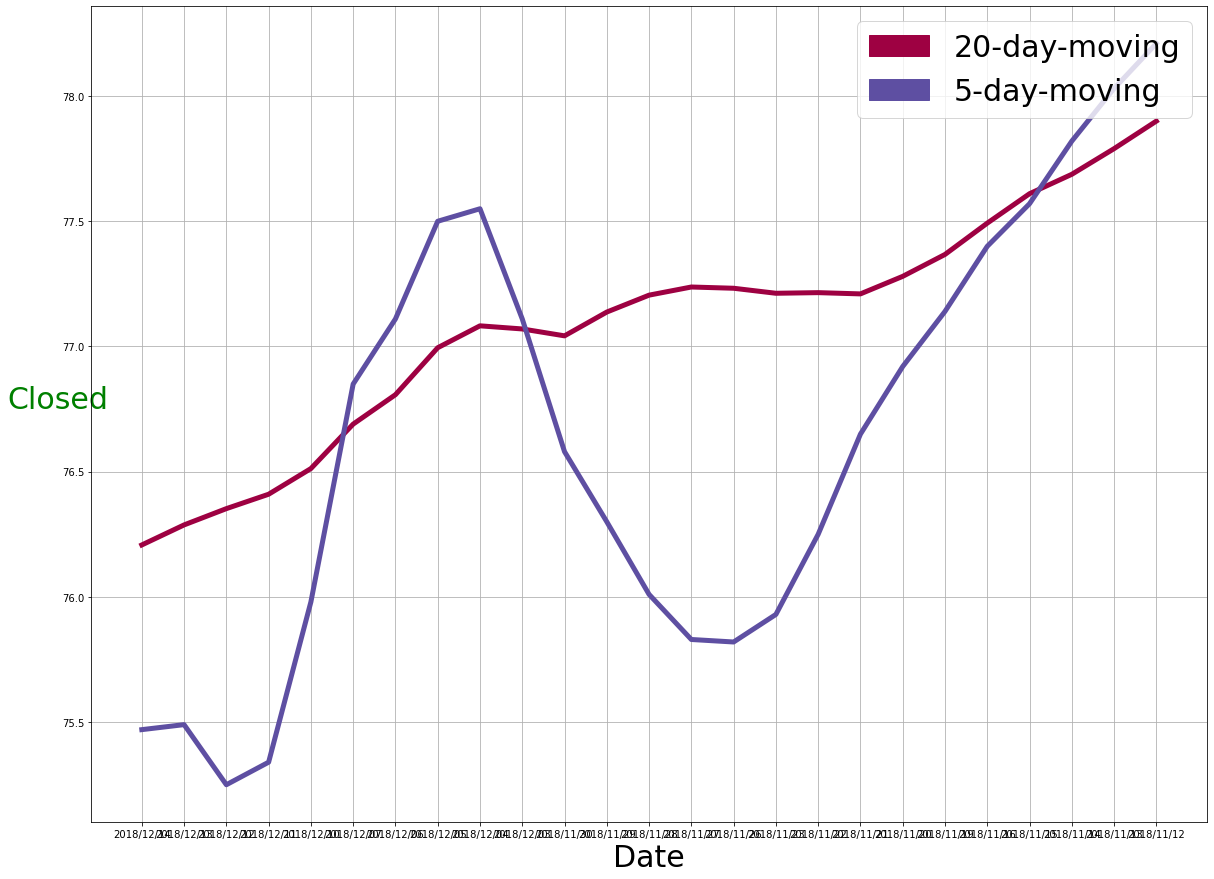

In [5]:
test_id='0050'
sampledates = ['2018-09-14','2018-12-14']
data = tejapi.get('TWN/APRCD', coid=[test_id],mdate={'gte':sampledates[0],'lte':sampledates[1]},opts={"sort":"mdate.desc",'columns':['coid','mdate','close_d','roib']}, paginate=True)    
data['mdate'] = pd.to_datetime(data['mdate'])
all_date = data['mdate'].unique()
show_data = []
print(len(all_date))
for i in range(0,len(all_date)-long_day):    
    #一樣計算以test_id指定的股票在sampledates內的長短天期均價，以便畫圖
    this_date = all_date[i]    
    long_avg_date,short_avg_date = all_date[i+long_day],all_date[i+short_day]
    closed = data.loc[(data['coid']==test_id)&(data['mdate']==this_date),'close_d'].values[0]
    l_mean = data.loc[(data['coid']==test_id)&(data['mdate']>long_avg_date)&(data['mdate']<=this_date),'close_d'].mean()
    s_mean = data.loc[(data['coid']==test_id)&(data['mdate']>short_avg_date)&(data['mdate']<=this_date),'close_d'].mean()
    show_data.append([this_date.strftime('%Y/%m/%d'),l_mean,s_mean])
#實際畫圖，果然與前一步驟檢查結果相同，    
print_moving(show_data)